In [451]:
import os
import numpy as np
import scipy
import librosa
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from python_speech_features import mfcc
%matplotlib inline

In [452]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

In [453]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [454]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [455]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs


In [456]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [457]:
def pad_audio(data, fs, T=3):
    # Calculate target number of samples
    N_tar = int(fs * T)
    # Calculate number of zero samples to append
    shape = data.shape
    # Create the target shape    
    N_pad = N_tar - shape[0]
    #print("Padding with %s seconds of silence" % str(N_pad/fs) )
    shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(shape),
                              data))
        else:
            return np.hstack((np.zeros(shape),
                              data))
    else:
        return data

In [458]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [459]:
def create_cepstral_coefficients(file):
    sample_rate, audio = wavfile.read(file)
    audio = pad_audio(audio, sample_rate)
    
    hop_size = 10#ms
    FFT_size = 1024

    audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)

    window = get_window("hann", FFT_size, fftbins=True)

    audio_win = audio_framed * window

    ind = 6

    audio_winT = np.transpose(audio_win)

    audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

    for n in range(audio_fft.shape[1]):
        audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

    audio_fft = np.transpose(audio_fft)

    audio_power = np.square(np.abs(audio_fft))

    freq_min = 0
    freq_high = sample_rate / 2
    mel_filter_num = 10
    
    filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)

    
    filters = get_filters(filter_points, FFT_size)

    # taken from the librosa library
    enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
    filters *= enorm[:, np.newaxis]

    audio_filtered = np.dot(filters, np.transpose(audio_power))
    audio_log = 10.0 * np.log10(audio_filtered)
    audio_log.shape

    dct_filter_num = 40

    dct_filters = dct(dct_filter_num, mel_filter_num)

    cepstral_coefficents = np.dot(dct_filters, audio_log)

    
    return cepstral_coefficents



In [460]:
import boto3

In [461]:
import os
# assign directory

# import glob

# output = []
# labels = []

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:

#         if 'chunk' in file:
#             labels.append(os.path.join(subdir, file).split('-')[3])
#             data = create_cepstral_coefficients(os.path.join(subdir, file))
#             where_are_NaNs = np.isnan(data)
#             data[where_are_NaNs] = 0
#             data[data == -np.inf] = 0
#             data[data == np.inf] = 0
#             output.append(data.flatten())
            


In [462]:
# cepstrals = np.array(output)

In [463]:
# from sklearn import svm

# clf = svm.SVC(gamma=0.001, C=100)
# #print(labels.shape)

# labels = np.array(labels).ravel()
# print(labels)
# #labels = np.concatenate(labels, axis=1)
# cepstrals.shape
# #clf.fit(cepstrals, labels)

In [464]:
# 


In [465]:
# X_train, X_test, y_train, y_test = train_test_split(cepstrals, labels, test_size=0.3,random_state=109) # 70% training and 30% test

In [466]:
# labels.ravel()

In [467]:
# clf.fit(X_train, y_train)

In [468]:
# y_pred = clf.predict(X_test)

In [469]:
# 
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [470]:
def load_audio():
    rootdir = 'dataset/'
    labels = []
    letters = []
    for subdir, dirs, files in os.walk(rootdir):

        for file in files:
            
            if 'chunk' in file:
                audio, sample_rate = librosa.load(os.path.join(subdir, file))

                data = pad_audio(audio, sample_rate)
                label = os.path.join(subdir, file).split('-')[3]
                letters.append((data, sample_rate, label))
              

    
    return letters

# How to use load_audio() function
characters = load_audio()

In [471]:
len(characters)

780

In [472]:
def extract_features(audio_data):

	# Remember that the audio data consists of raw audio wave followed by sample rate
	# so we need to only take the raw audio wave.
    output, label_output = [],[]

    for i in audio_data:

        audio_waves = i[0]
        samplerate = i[1]
        letter = i[2]
        n_fft = int(samplerate * 0.02)  
        hop_length=n_fft // 2
        data = mfcc(audio_waves, samplerate=samplerate, nfft=n_fft)
        label_output.append(letter)
        features = np.array(data)
        output.append(features.flatten())

    label_output = np.array(label_output)
    return output, label_output

# Define a function to load the raw audio files

character_features, labels = extract_features(characters)

In [473]:
character_features


[array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),
 array([-3.60436534e+01,  0.00000000e+00,  0.00000000e+00, ...,
         9.64028692e-15,  0.00000000e+00,  0.00000000e+00]),


In [474]:
labels

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D',
       'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'G', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
       'H', 'H', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'J',
       'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q',
       'Q', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'S

In [475]:
for idx, val in enumerate(character_features):
    print(val.shape, labels[idx])


(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) A
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) B
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) C
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) D
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) E
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) F
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) G
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) H
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) I
(3874,) J
(3874,) J
(3874,) J
(3874,) J
(3874,) J
(3874,) J
(3874,) J
(3874,) J
(3874,) J
(3874,) J


In [476]:
labels

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D',
       'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'G', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
       'H', 'H', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'J',
       'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q',
       'Q', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'S

In [486]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X = character_features
Y = labels

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=30)
y_train

array(['E', 'Q', 'T', 'X', 'I', 'R', 'H', 'V', 'O', 'C', 'X', 'F', 'N',
       'B', 'O', 'T', 'I', 'K', 'B', 'P', 'V', 'M', 'Z', 'P', 'A', 'I',
       'F', 'P', 'J', 'Y', 'T', 'T', 'Z', 'H', 'H', 'Q', 'D', 'M', 'M',
       'D', 'O', 'T', 'E', 'E', 'J', 'C', 'Y', 'S', 'Y', 'O', 'N', 'B',
       'O', 'B', 'G', 'M', 'L', 'S', 'C', 'U', 'O', 'S', 'Y', 'H', 'E',
       'K', 'U', 'A', 'P', 'M', 'W', 'R', 'M', 'L', 'I', 'M', 'C', 'Z',
       'M', 'B', 'E', 'V', 'F', 'W', 'O', 'Z', 'J', 'I', 'K', 'R', 'X',
       'S', 'I', 'S', 'J', 'S', 'N', 'Q', 'J', 'Y', 'M', 'U', 'V', 'K',
       'P', 'T', 'Y', 'D', 'M', 'F', 'L', 'H', 'E', 'O', 'U', 'T', 'K',
       'W', 'R', 'Z', 'G', 'K', 'U', 'N', 'A', 'R', 'W', 'R', 'G', 'T',
       'L', 'Y', 'K', 'R', 'J', 'C', 'J', 'H', 'W', 'O', 'Y', 'Q', 'Q',
       'Y', 'C', 'S', 'X', 'W', 'Q', 'S', 'N', 'T', 'F', 'U', 'D', 'F',
       'Q', 'J', 'S', 'S', 'J', 'A', 'D', 'E', 'Y', 'M', 'L', 'E', 'Z',
       'W', 'K', 'C', 'R', 'E', 'P', 'O', 'N', 'D', 'L', 'E', 'V

In [487]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# params_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
#           'gamma': [0.0001, 0.001, 0.01],
#           'kernel':['rbf'] }
# grid_clf = GridSearchCV(SVC(), params_grid)

# #Fit the data with the best possible parameters
# grid_clf = grid_clf.fit(X_train, y_train)

# #Print the best estimator with it's parameters
# params = grid_clf.best_params_


In [488]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')

In [489]:
clf.fit(X_train, y_train)

SVC()

In [490]:
y_pred = clf.predict(X_test)

In [491]:
y_pred


array(['B', 'K', 'D', 'J', 'J', 'J', 'Y', 'Q', 'M', 'R', 'I', 'P', 'G',
       'Q', 'W', 'P', 'O', 'N', 'I', 'N', 'N', 'Y', 'Y', 'W', 'Q', 'E',
       'A', 'N', 'N', 'O', 'A', 'S', 'O', 'T', 'J', 'H', 'K', 'U', 'N',
       'Y', 'I', 'E', 'J', 'W', 'G', 'T', 'H', 'B', 'K', 'A', 'G', 'Y',
       'O', 'D', 'C', 'R', 'O', 'N', 'S', 'T', 'A', 'E', 'C', 'J', 'J',
       'S', 'X', 'N', 'U', 'I', 'W', 'W', 'W', 'Y', 'Q', 'C', 'I', 'Z',
       'F', 'X', 'U', 'H', 'I', 'W', 'M', 'U', 'I', 'J', 'Q', 'A', 'N',
       'U', 'J', 'P', 'M', 'D', 'L', 'I', 'U', 'J', 'Z', 'D', 'N', 'P',
       'D', 'Z', 'I', 'H', 'K', 'I', 'W', 'F', 'Q', 'Y', 'W', 'M', 'I',
       'Z', 'W', 'G', 'W', 'P', 'N', 'F', 'I', 'M', 'M', 'D', 'I', 'N',
       'E', 'Y', 'I', 'I', 'I', 'N', 'G', 'O', 'I', 'A', 'J', 'Q', 'B',
       'R', 'Y', 'Y', 'I', 'O', 'Z', 'N', 'D', 'I', 'W', 'N', 'F', 'J',
       'J', 'B', 'B', 'J', 'I', 'R', 'Q', 'K', 'J', 'Q', 'O', 'Z', 'S',
       'Z', 'K', 'Q', 'A', 'K', 'D', 'U', 'I', 'F', 'H', 'R', 'X

In [492]:
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.5854700854700855


/home/brucebeck/.local/share/virtualenvs/Masters-Vwceh9VJ/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


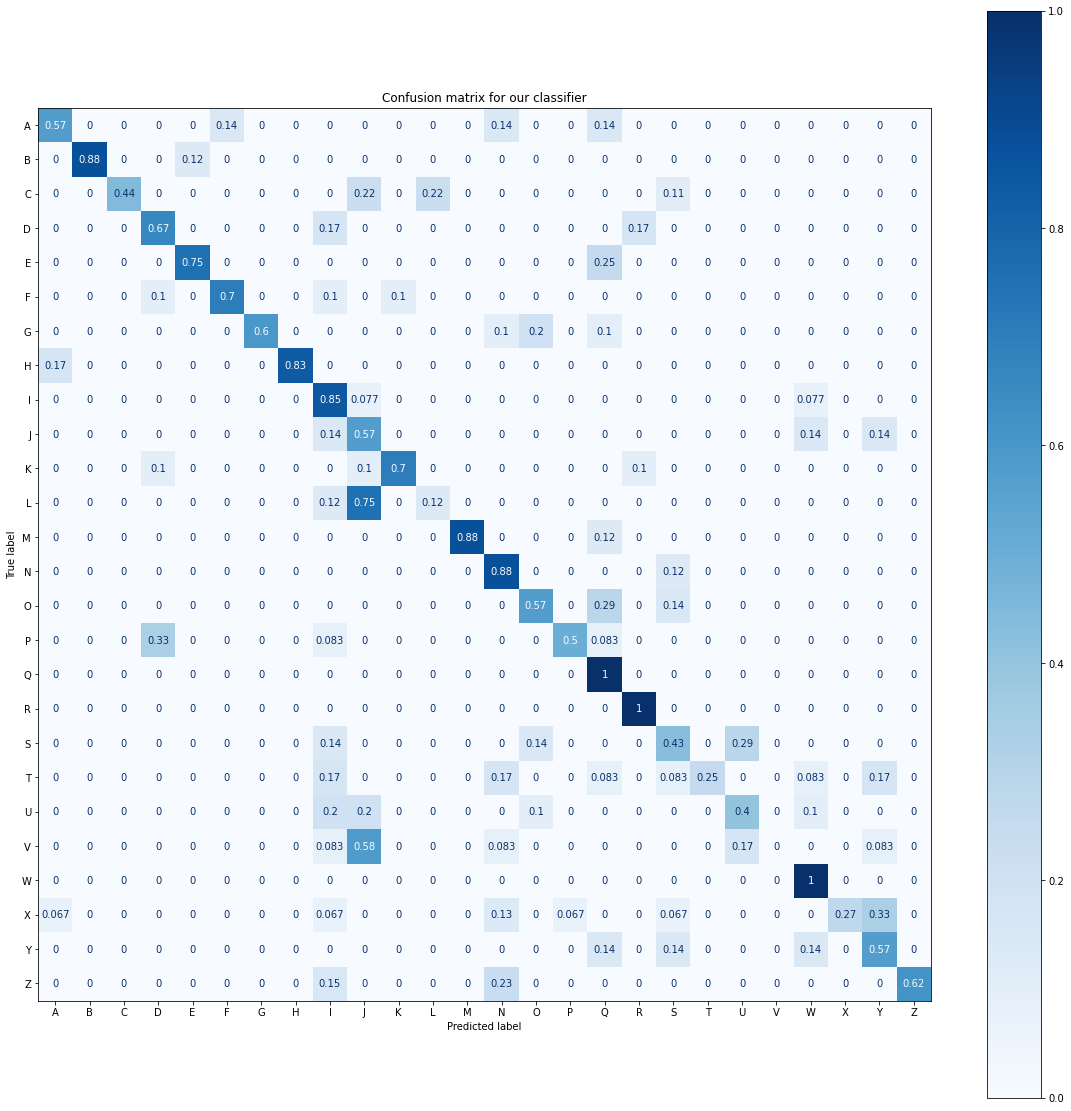

In [493]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(20, 20))
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax=ax)
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()


In [485]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      0.53      0.70        15
           B       0.80      0.89      0.84         9
           C       0.75      0.43      0.55         7
           D       0.78      0.64      0.70        11
           E       1.00      0.73      0.84        11
           F       1.00      0.90      0.95        10
           G       1.00      0.71      0.83         7
           H       0.88      0.70      0.78        10
           I       0.30      0.80      0.43        10
           J       0.00      0.00      0.00        10
           K       0.45      0.83      0.59         6
           L       0.27      0.86      0.41         7
           M       1.00      0.67      0.80        12
           N       0.75      0.33      0.46         9
           O       0.44      0.67      0.53         6
           P       1.00      0.33      0.50         9
           Q       0.19      0.83      0.31         6
           R       1.00    